# Summary of Findings


### Introduction
In this project, I will build a model to predict the outcome of an allegation. As "outcome_descroption" in the data is a nominal variable, I treat my prediction problem as a classification problem, that is, classifying different outcomes based on selected features and then make predictions. The evaluation metric I choose for my model is the accuracy. This is because the aim of improving my model is to increase the proportin of predictions that are correct, so I will treat all correct/incorrect guesses equally.


### Baseline Model
In my baseline model, I use RandomForestClassifier and include 3 generic features that I think would most likley to affect the outcome

1.1 "rank_incident": ordinal
- Police with higher ranks are more experienced, so that they may be less likely to have severe misconduct, and thus the outcome of the complaints they received may be more positive than those in lower ranks. 


1.2 "mos_gender": nominal
- There may be some tendencies when making the sanction for police in different gender groups. For example, police in certain gender group may be less likely to sanctioned as misconduct by NYPD at the end


1.3 "open_length": quantitative
- Complaints with shorter open length may be decided more easily, so that they are more likely to fall into similar outcomes categories, so open length may indicate the outcome.


The average R^2 of my baseline model is about 0.390. The baseline model only explains 38.9% of the variablility of the response variable. The accuracy of the baseline model is 0.388, which needs further improvements.

### Final Model

In my final model, I still use the RandomForestClassifier with the previous 3 features, but add 3 more engineered features:

2.1 standard scaled "open_length" within differnet "fado_type" groups: quantitative
- Different FADO types may also have different open length, so I standard scaled "open_length" within differnet "fado_type" groups.


2.2 "allegation" is binned into several major categories: nominal
- Different types of allegations may have an impact on the outcome. Some allegations may be more severe than others, so that the outcome may also be more severe. I binned some types of allegations into major ones to make the types more general.


2.3 "unique_mos_id" is engineered to the number of times each one appears in records: quantitative
- There may be police who often receive complaints, which may indicate they are more likely to have misconduct, so that they are more likely to receive more severe outcomes. So I incorporate the counts of the occurrence of each mos id in records.

The average R^2 of my final model is about 0.434. And the accuracy of the final model is 0.431. The performance of my final model is better than that of the baseline model.

I then use GridSearchCV to perform a search for the best model and parameters:

- The average over the cross-validation fold scores of the best model is 0.438. 

- I find the best parameters for my model are: max_depth=15, min_samples_leaf=5, min_samples_split=5, n_estimators=12. 

- The resulting R^2 increases to 0.435. So now the final model explains 43.5% of the variability of the response variable. And the accuracy now also increases to 0.435.


### Fairness Evaluation
I want to explore whether my model is fairer for male police than female police, so I choose "mos_gender" to construct my interesting subset. I then split my subset into two subsets by "mos_gender" and run a permutation test with R^2 as the test statistics. This is because I care more about how my model fits the data in female and male police subset, or whether it is biased (more well-fitted) to a gender.

Permutation test with the significance level of 95%:

- Null Hypothesis: My model is fair, and the R^2 for my two subsets are roughly the same
- Alternative Hypothesis: My model is unfair, and the R^2 for the male subset is higher than the female subset

I get a p-value of 0.81 > 0.05 from my permutation test, so I fail to reject the null hypothesis and it is very likely that my model is fair on different genders of the police.

# Code

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import datetime
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures


from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score

#### Data Cleaning

In [2]:
df = pd.read_csv('data/allegations_202007271729.csv')

In [3]:
# Replace unknown with null values
df = df.replace('Unknown', np.NaN)

In [4]:
# Combine receive date related columns to create datetime object for receive date
receive = df[['month_received', 'year_received']]
receive = receive.rename(columns = {'month_received' : 'month' , 'year_received' : 'year'})
receive = receive.assign(day = 1)
receive_date = pd.to_datetime(receive[["month", "year","day"]])
df = df.assign(receive_date = receive_date)

# Combine close date related columns to create datetime object for close date
close = df[['month_closed', 'year_closed']]
close = close.rename(columns = {'month_closed' : 'month' , 'year_closed' : 'year'})
close = close.assign(day = 1)
close_date = pd.to_datetime(close[["month", "year","day"]])
df = df.assign(close_date = close_date)

In [5]:
# Compute the length of open time for each complaint based on "receive_date" and "close_date", 
# and add a column "open_length" to the dataset:
df = df.assign(open_length = df['close_date'] - df['receive_date'])
df.open_length = df.open_length.dt.days

### Baseline Model

Only incorporate 3 generic features that I think are most likely to affect the outcome:
1. "rank_incident": ordinal
2. "mos_gender": nomial
3. "open_length": quantitative

In [6]:
# Ordinal encoding the rank of officers
df['ordinal_rank_incident'] = df.rank_incident.map({'Police Officer':0, 'Detective':1, 
                                                    'Sergeant':2, 'Lieutenant':3,
                                                    'Captain':4, 'Deputy Inspector':5, 
                                                    'Inspector':6, 'Chiefs and other ranks':7
                                                    })

In [44]:
# Build baseline model with these 3 features
cats = Pipeline([
    ('ohe', OneHotEncoder(sparse=False, handle_unknown = 'ignore')), 
    ('pca', PCA(svd_solver='full'))
])
catcols = ['mos_gender']

nums = Pipeline([('std_scaling', StandardScaler())])
numcols = ['ordinal_rank_incident', 'open_length']

ct = ColumnTransformer([
    ('catcols', cats, catcols),
    ('numcols', SimpleImputer(strategy='constant', fill_value=0), numcols)
])

pl = Pipeline([('feats', ct), 
               ('classifier', RandomForestClassifier(max_depth=10,
                                                           min_samples_leaf=2, 
                                                           min_samples_split=2,
                                                           n_estimators=5)
               )
              ])

In [45]:
# features
va_df = df.dropna(axis = 0)
X = va_df[['open_length',
           'ordinal_rank_incident', 
           'mos_gender'
         ]]

# outcome
y = va_df.outcome_description
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

rsqr_lst = []
for i in range(200):
    pl.fit(X_train, y_train);
    rsqr = pl.score(X_test, y_test)
    rsqr_lst.append(rsqr)
np.mean(rsqr_lst)

0.39261102941176473

The R^2 for my baseline model is only 0.390.

In [48]:
pred = pl.predict(X_test)
accuracy_score(y_test, pred)

0.4314705882352941

The accuracy of the baseline model is 0.388, which needs further improvements.

### Final Model

I incorporate three more engineered features in the final model: 
1. "open_length" is standard scaled within differnet "fado_type" groups
2. "allegation" is binned into several major categories
3. "unique_mos_id" is enginnered as the number of times each one appears in records and save as "id_cnt"

In [10]:
# Design StdScalerByGroup Transformer for standard scaling "open_length"
# within differnet "fado_type" groups

from sklearn.base import BaseEstimator, TransformerMixin
class StdScalerByGroup(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        :Example:
        >>> cols = {'g': ['A', 'A', 'B', 'B'], 'c1': [1, 2, 2, 2], 'c2': [3, 1, 2, 0]}
        >>> X = pd.DataFrame(cols)
        >>> std = StdScalerByGroup().fit(X)
        >>> std.grps_ is not None
        True
        """
        # X may not be a pandas dataframe (e.g. a np.array)
        df = pd.DataFrame(X)

        # A dictionary of means/standard-deviations for each column, for each group.
        colname = df.columns
        grp_mean = df.groupby(colname[0]).aggregate(np.mean)
        grp_mean.columns = [i + '_mean' for i in grp_mean.columns]
        grp_sd = df.groupby(colname[0]).aggregate(np.std)
        grp_sd.columns = [i + '_sd' for i in grp_sd.columns]
        
        self.grps_ = pd.concat([grp_mean, grp_sd], axis = 1)

        return self
    
    def transform(self, X, y=None):
        """
        :Example:
        >>> cols = {'g': ['A', 'A', 'B', 'B'], 'c1': [1, 2, 3, 4], 'c2': [1, 2, 3, 4]}
        >>> X = pd.DataFrame(cols)
        >>> std = StdScalerByGroup().fit(X)
        >>> out = std.transform(X)
        >>> out.shape == (4, 2)
        True
        >>> np.isclose(out.abs(), 0.707107, atol=0.001).all().all()
        True
        """

        try:
            getattr(self, "grps_")
        except AttributeError:
            raise RuntimeError("You must fit the transformer before tranforming the data!")


        # Define a helper function here?
        def zscore (df, grp, col):
            mean = self.grps_.loc[grp, col + '_mean']
            sd = self.grps_.loc[grp, col + '_sd']
            df.loc[grp, col] = df.loc[grp, col].apply(lambda x: (x - mean) / sd)

        
        # X may not be a dataframe (e.g. np.array)
        df = pd.DataFrame(X)
        colname = df.columns
        grpcol = colname[0]
        df = df.set_index(grpcol)
        grps_name = df.index.unique()
        cols_name = df.columns
        for grp in grps_name:
            for col in cols_name:
                zscore(df, grp, col)
        
        return df

In [11]:
# Functions to bin "allegation" into several major categories

def categorize_alle(alle): 
    if alle in ['Word', 'Threat of arrest']:
        cate = 'Word'
    elif alle in ['Stop', 'Vehicle stop']:
        cate = 'Stop'
    elif alle in ['Search (of person)', 'Frisk', 'Vehicle search']:
        cate = 'Search'
    elif alle in ['Premises entered and/or searched', 'Refusal to provide name/shield number']:
        cate = 'Special'    
    else:
        cate = 'Force'
    return cate


def cate_on_alle(alle_col):
    df = pd.DataFrame(alle_col)
    df.allegation = df.allegation.apply(lambda x: categorize_alle(x))
    return df

# Add the binned allegation back to dataframe
df['binned_alle'] = cate_on_alle(df.allegation)

In [12]:
# Add a column that contains counts of each id in "unique_mos_id" column
id_cnt = dict(df.unique_mos_id.value_counts())
df['id_cnt'] = df.unique_mos_id.apply(lambda x: id_cnt[x])

In [52]:
cats = Pipeline([
    ('ohe', OneHotEncoder(sparse=False, handle_unknown = 'ignore')), 
    ('pca', PCA(svd_solver='full'))
])
catcols = ['mos_gender', 'binned_alle']

nums = Pipeline([('std_scaling', StandardScaler())])
numcols = ['ordinal_rank_incident', 'id_cnt',]

ct = ColumnTransformer([
    ('StdScaler', StdScalerByGroup(), ['fado_type', 'open_length']),
    ('catcols', cats, catcols),
    ('numcols', SimpleImputer(strategy='constant', fill_value=0), numcols)
])

pl = Pipeline([
               ('feats', ct),           
               ('classifier', RandomForestClassifier(max_depth=10, 
                                                     min_samples_leaf=2, 
                                                     min_samples_split=2,
                                                     n_estimators=5)
               )
              ])

In [ ]:
# features
va_df = df.dropna(axis = 0)
X = va_df[[
           'ordinal_rank_incident',      
           'mos_gender', 
           'fado_type', 
           'open_length',
           'binned_alle',
           'id_cnt'
           
           ]]

# outcome
y = va_df.outcome_description
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
   
rsqr_lst = []
for i in range(200):
    pl.fit(X_train, y_train);
    rsqr = pl.score(X_test, y_test)
    rsqr_lst.append(rsqr)
np.mean(rsqr_lst)

The average R^2 for my final model is only 0.434, so the model fits the data better than the baseline model.

In [51]:
pred = pl.predict(X_test)
accuracy_score(y_test, pred)

0.4314705882352941

The accuracy of the final model is 0.431.

Next, I perform a search for the best model parameters using GridSearchCV

In [16]:
parameters = {
    'classifier__max_depth': [10,13,15,17,19], 
    'classifier__min_samples_split':[5,7,9],
    'classifier__min_samples_leaf':[5,7,9],
    'classifier__n_estimators': [9,10,11,12,13]
}

In [17]:
grids = GridSearchCV(pl, param_grid=parameters, cv=4, return_train_score=True)

In [18]:
grids.fit(X_train, y_train);

In [19]:
grids.best_params_

{'classifier__max_depth': 15,
 'classifier__min_samples_leaf': 5,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 12}

In [20]:
grids.best_estimator_.score(X_test, y_test)

0.435

With the best parameters, R^2 of the model now increases to 0.435.

In [50]:
grids.best_score_

0.4375

The average over the cross-validation fold scores of the best model is 0.438.

In [22]:
pred = grids.best_estimator_.predict(X_test)
accuracy_score(y_test, pred)

0.435

The accuracy of the final model with the best parameters is 0.435.

In [26]:
pl_bst = Pipeline([
               ('feats', ct),           
               ('classifier', RandomForestClassifier(max_depth=15, 
                                                     min_samples_leaf=5, 
                                                     min_samples_split=5,
                                                     n_estimators=12)
               )
              ])

### Fairness Evaluation

I want to explore whether my model is fairer for female police or male police, so I will choose "mos_gender" to construct my interesting subset. I then split my subset into two subsets by "mos_gender". 

In [27]:
subdf = va_df[[
           'ordinal_rank_incident', 
           'mos_gender', 
           'fado_type', 
           'open_length',
           'binned_alle',
           'id_cnt',
           'outcome_description'    
           ]]

For my parity measure, I will pick R^2 as the objective and run a permutation test, I choose the significance level of 95%:
- Null Hypothesis: My model is fair, and the R^2 for my two subsets are roughly the same
- Alternative Hypothesis: My model is unfair, and the R^2 for the male subset is higher than the female subset


In [38]:
n_repetitions = 100

differences = []
for _ in range(n_repetitions):
    
    # shuffle mos_gender
    shuffled_gender = (
        subdf['mos_gender']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )
    
    # put them in a table
    shuffled = (
        subdf
        .assign(**{'Shuffled Gender': shuffled_gender})
    )
    
    # compute the R^2 of model on female and male subsets
    F = shuffled[shuffled['Shuffled Gender'] =='F']
    M = shuffled[shuffled['Shuffled Gender'] =='M']
    
    X_F = F[['ordinal_rank_incident', 
           'mos_gender', 
           'fado_type', 
           'open_length',
           'binned_alle',
           'id_cnt']]
    y_F = F.outcome_description

    X_M = M[['ordinal_rank_incident', 
               'mos_gender', 
               'fado_type', 
               'open_length',
               'binned_alle',
               'id_cnt']]
    y_M = M.outcome_description
    
    X_F_train, X_F_test, y_F_train, y_F_test = train_test_split(X_F, y_F, test_size=0.25)
    X_M_train, X_M_test, y_M_train, y_M_test = train_test_split(X_M, y_M, test_size=0.25)
    
    pl_bst.fit(X_F_train, y_F_train);
    preds_F = pl_bst.predict(X_F_test)
    FR2 = pl_bst.score(X_F_test, y_F_test)
    
    pl_bst.fit(X_M_train, y_M_train);
    preds_M = pl_bst.predict(X_M_test)
    MR2 = pl_bst.score(X_M_test, y_M_test)
    
    # diffenerce in R^2
    diff = FR2 - MR2
    
    # add it to the list of results
    differences.append(diff)

In [39]:
# observed difference of R^2 of model on female and male subsets
F = subdf[subdf.mos_gender =='F']
M = subdf[subdf.mos_gender =='M']
X_F = F[['ordinal_rank_incident', 
           'mos_gender', 
           'fado_type', 
           'open_length',
           'binned_alle',
           'id_cnt']]
y_F = F.outcome_description

X_M = M[['ordinal_rank_incident', 
           'mos_gender', 
           'fado_type', 
           'open_length',
           'binned_alle',
           'id_cnt']]
y_M = M.outcome_description

X_F_train, X_F_test, y_F_train, y_F_test = train_test_split(X_F, y_F, test_size=0.25)
X_M_train, X_M_test, y_M_train, y_M_test = train_test_split(X_M, y_M, test_size=0.25)

pl_bst.fit(X_F_train, y_F_train);
preds_F = pl_bst.predict(X_F_test)
FR2 = pl_bst.score(X_F_test, y_F_test)

pl_bst.fit(X_M_train, y_M_train);
preds_M = pl_bst.predict(X_M_test)
MR2 = pl_bst.score(X_M_test, y_M_test)

obs = FR2 - MR2
obs

-0.06541224616890196

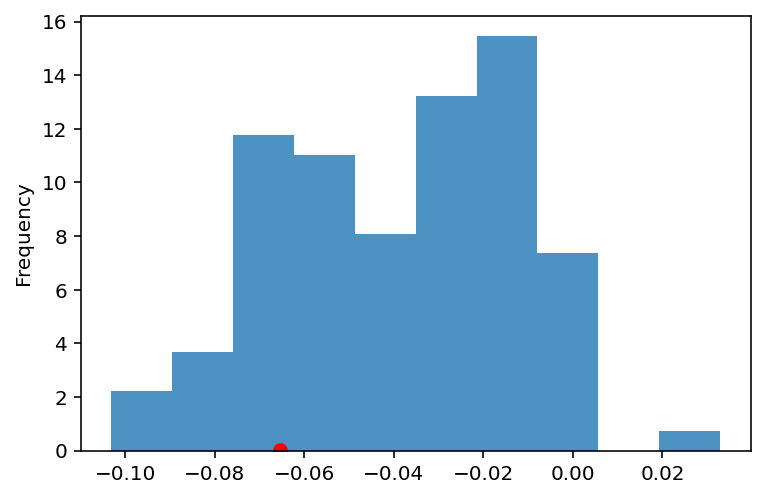

In [40]:
# visualize the observed differnce of R^2 with respect to the simulation result
pd.Series(differences).plot(kind='hist', density=True, alpha=0.8)
plt.scatter(obs, 0.01, color='red', s=40, zorder=2);

In [41]:
# calculate p-value
pval = np.count_nonzero(differences >= obs) / n_repetitions
pval

0.81

Here, I get a p-value of 0.81, so that I fail to reject the null hypothesis and it is very likely that my model is fair on different genders of the police, since the R^2 for my two gender subsets are roughly the same from the simulation test.